<a href="https://colab.research.google.com/github/lazy-monster/Chair-Sofa-Bench/blob/main/notebookb5587a3910_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install difpy
!pip install duckduckgo_search
from fastdownload import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.vision.widgets import *
from ipywidgets import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for difpy: filename=difPy-2.4.5-py3-none-any.whl size=8805 sha256=805b95158e68b374648a263e9c8194cd868af03f745ea4e8260772d733d1bcb3
  Stored in directory: /root/.cache/pip/wheels/42/e4/ea/9dd7c8a9b7dd22dcc3e78f6898f3243e291ac8ef6c6abaf1d5
Successfully built difpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip'

In [ ]:
import os as os

My project for the chapter 2 of the fast.ai book will be to create a model to identify chairs, sofas and benches.

In the code below, I've borrowed a function from Jeremy's [bird identifier notebook](http://https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). It will assist in easily searching for the images.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Next I'll check if the search function can bring what I need:

Searching for 'chair images'


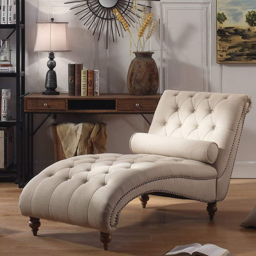

In [ ]:

url = search_images('chair images', max_images=1)
download_url(url[0], 'chair.jpg', show_progress=True)

from fastai.vision.all import *

im = Image.open('chair.jpg')
im.to_thumb(256, 256)


Nice, now for sofa pictures:

Searching for 'sofa images'


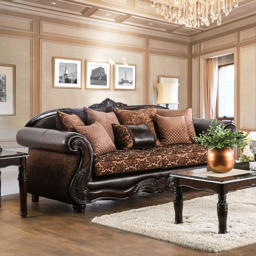

In [ ]:

url = search_images('sofa images', max_images=1)
download_url(url[0], 'sofa.jpg', show_progress=True)

im = Image.open('sofa.jpg')
im.to_thumb(256, 256)

Good. Next for the benches:

Searching for 'bench images'


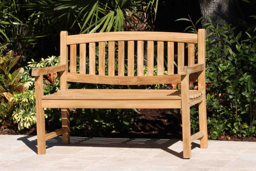

In [ ]:
url = search_images('bench images', max_images=1)
download_url(url[0], 'bench.jpg', show_progress=True)

im = Image.open('bench.jpg')
im.to_thumb(256, 256)

Looks good, even though it doesn't change the image every time I run the code. Is that because the search brings the same result and so the program picks the same image every time?

Next I'll download 100 images of each category by borrowing Jeremy's code again since I don't know all those functions...

In [ ]:
searches = 'chair image','sofa image', 'bench image'
path = Path('chair_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', max_images=100))



Searching for 'chair image'
Searching for 'sofa image'
Searching for 'bench image'


Good. Now to remove failed images;

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

To identify duplicates in the dataset:

In [ ]:
from difPy import dif
search = dif("chair_or_not")
duplicates = search.lower_quality
duplicates


DifPy preparing files: [277/277] [100%]
DifPy comparing images: [274/274] [100%]
Found 0 images with one or more duplicate/similar images in 34.1327 seconds.


[]

In [ ]:
# this deletes the duplicates - I'm not yet sure if it leaves a copy of each batch of
# duplicates. UPDATE: I checked the length of the duplicates list using len(duplicates)
# and the value returned was 199. The number of images with one or more duplicates returned by
# difpy was 115. Since the number of duplicates (including the highest quality ones) was supposed
# to be at least 2 times 115, I concluded that the lower_quality function doesn't return some images (hopefully the highest quality ones)

for duplicate in duplicates:
  Image.open(duplicate)  # also don't know why this doesn't work
  os.remove(duplicate)

In [ ]:
#this is to see how many images are left in the path

def count(item):
  count = 0
  dir = os.listdir('chair_or_not/' + item)
  for d in dir:
    count += 1
  print(count)


for item in ['chair image', 'sofa image', 'bench image']:
  count(item)

96
96
82


And now we create our dataloader;

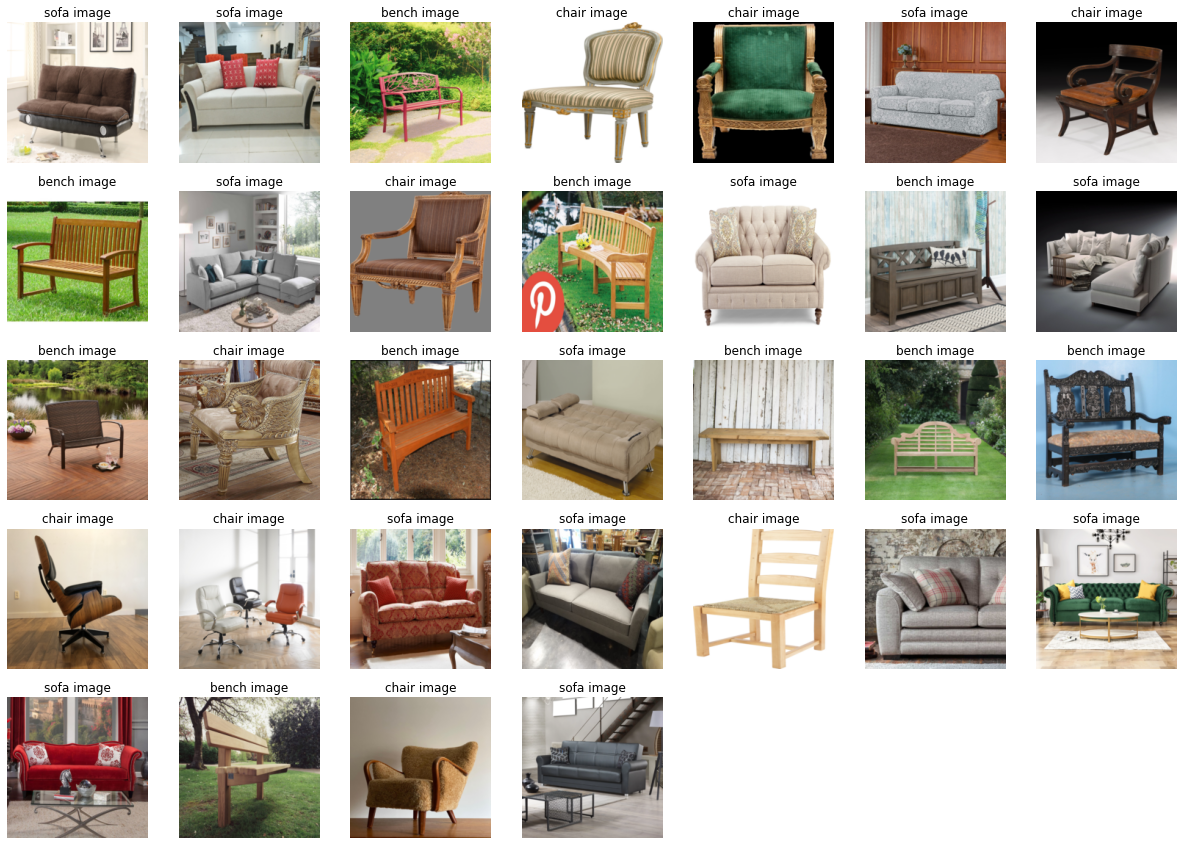

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]).dataloaders(path, bs=32)  #,batch_tfms=aug_transforms()

dls.show_batch(max_n=100)

And then train our model;

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

To clean the data, we take a few steps:
1. Plotting a confusion matrix: This is to see exactly which categories the model is having problems with.

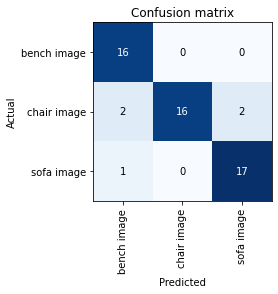

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

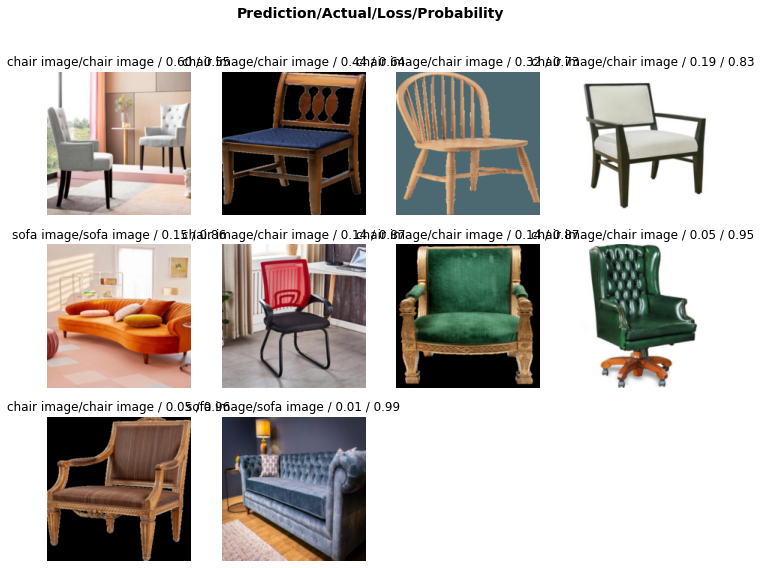

In [ ]:
interp.plot_top_losses(10, nrows=3)

In [ ]:
ImageClassifierCleaner(learn)

Since there are no problems with the dataset, there's no need to retrain the model.

In [ ]:
learn.export('model.pkl')

In [ ]:
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>